In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
bankloan = pd.read_csv("bankloan.csv", na_values='#NULL!')

In [3]:
bankloan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176.0,9.3,11.36,5.01,1.0
1,27,1,10,6,31.0,17.3,1.36,4.00,0.0
2,40,1,15,14,55.0,5.5,0.86,2.17,0.0
3,41,1,15,14,120.0,2.9,2.66,0.82,0.0
4,24,2,2,0,28.0,17.3,1.79,3.06,1.0


In [4]:
#bankloan['ed'] = bankloan['ed'].astype('category')
bankloan_known = bankloan[~bankloan.default.isnull()]
bankloan_known['default'] = bankloan_known['default'].astype('int')
bankloan_unknown = bankloan[bankloan.default.isnull()]

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
model_tree = DecisionTreeClassifier(criterion='entropy')

In [12]:
model_tree.fit(X=bankloan_known.drop('default',axis=1),y=bankloan_known['default'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

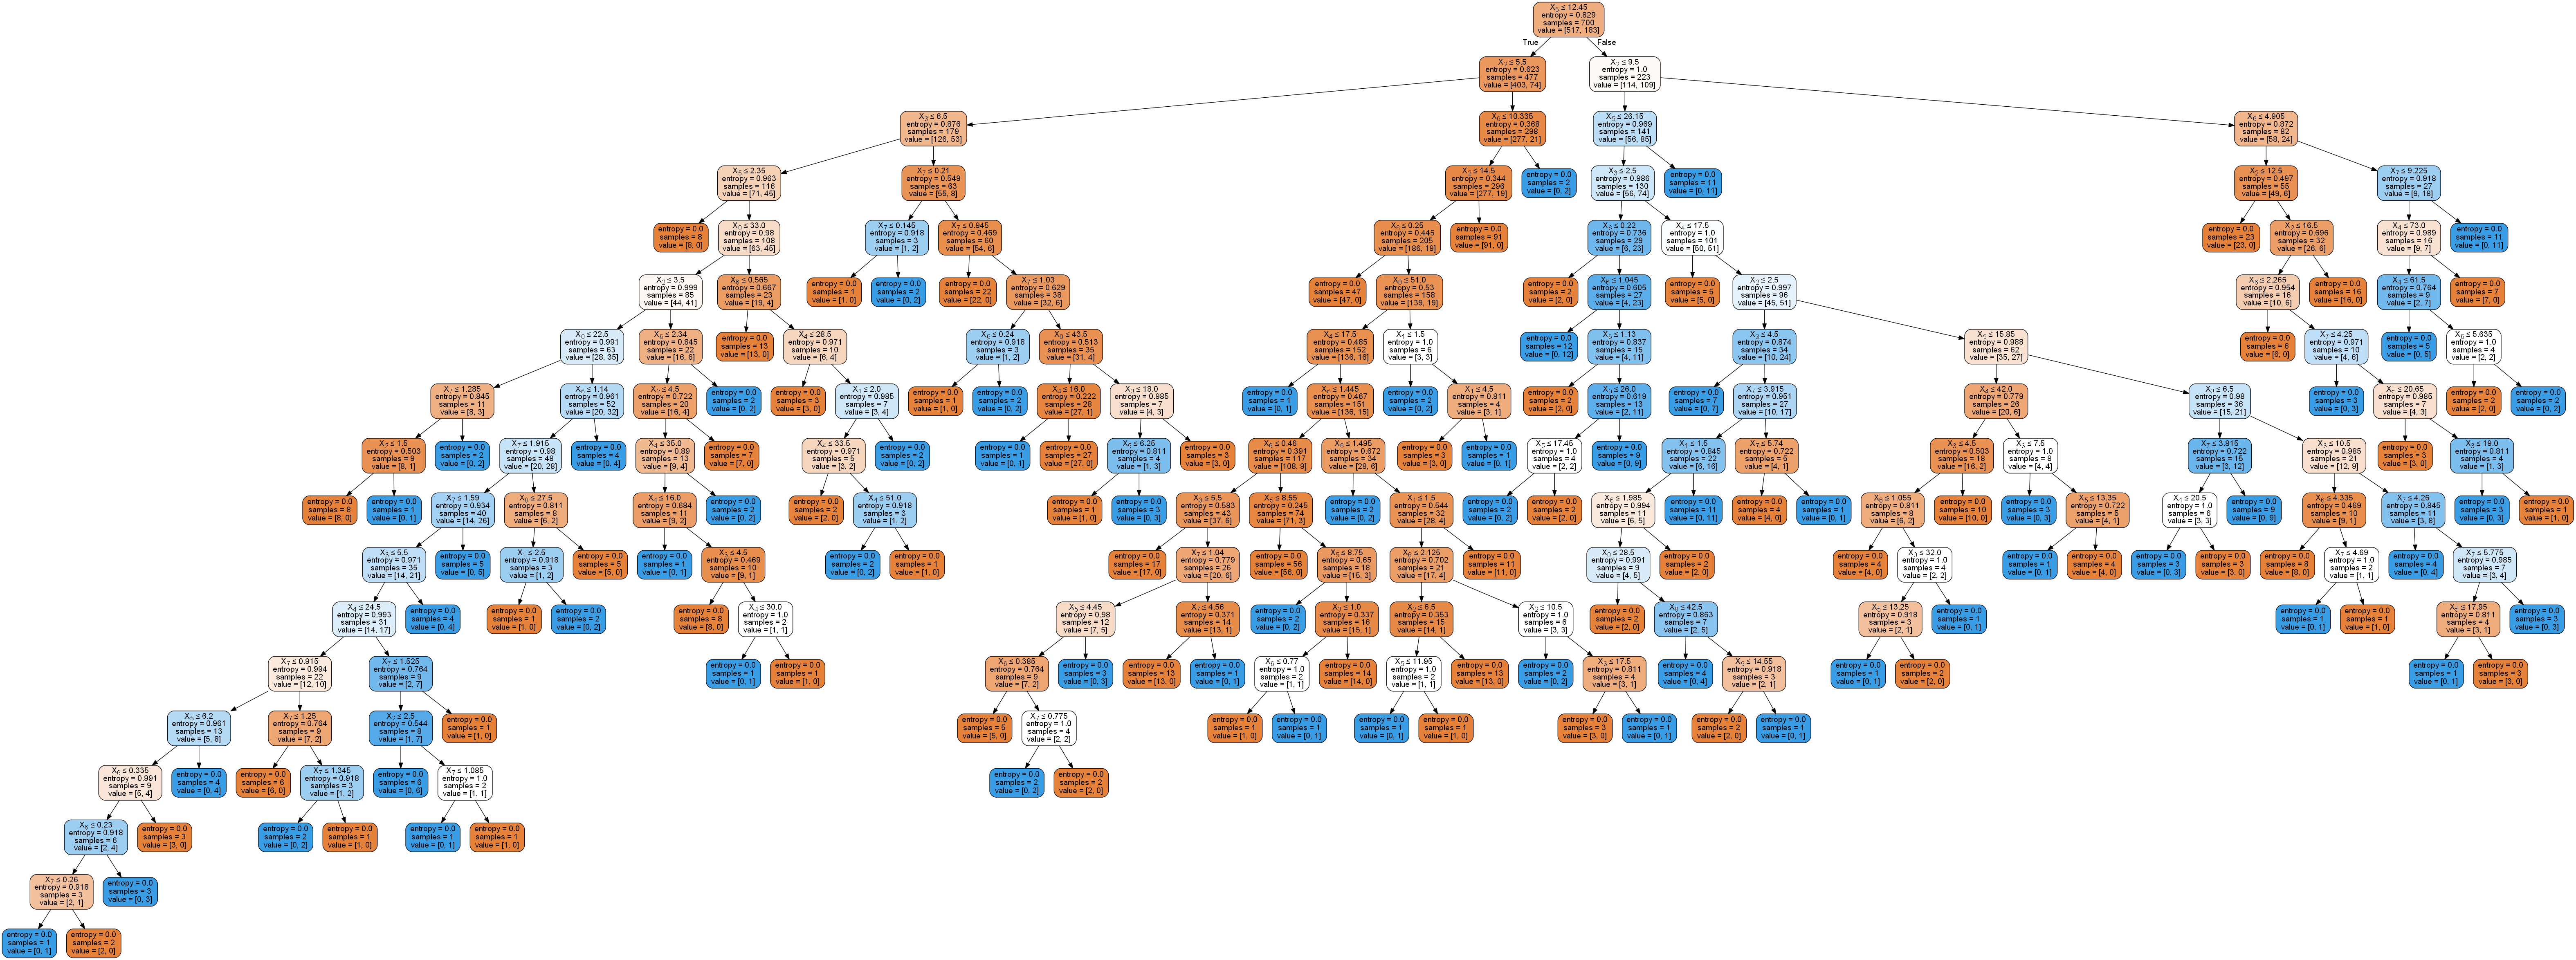

In [13]:
dot_data = StringIO()

export_graphviz(model_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, proportion=False)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#dot_data.close()

In [14]:
pred_tree_training = model_tree.predict(X = bankloan_known.drop('default',axis=1))

In [15]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score
print(confusion_matrix(pred_tree_training,bankloan_known['default']))
print(cohen_kappa_score(pred_tree_training,bankloan_known['default']))
print(accuracy_score(pred_tree_training,bankloan_known['default']))

[[517   0]
 [  0 183]]
1.0
1.0


In [16]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [17]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(bankloan_known.drop('default', axis=1),bankloan_known['default'], 
                                                    test_size=0.4, random_state=12345)

In [18]:
grid_param = {'criterion':['gini','entropy'], 'max_depth':[3,4,6]}
final_tree = GridSearchCV(model_tree, param_grid=grid_param,cv=5,n_jobs=-1, scoring = 'accuracy')
final_tree.fit(X=Train_X, y=Train_Y)
cross_val_score(final_tree, X=Train_X, y=Train_Y,cv=5).mean()

0.76456953865883703

In [19]:
final_tree.best_params_

{'criterion': 'gini', 'max_depth': 3}

In [20]:
pred_tree = final_tree.predict(X=Test_X)
print(confusion_matrix(pred_tree, Test_Y))
print(accuracy_score(pred_tree, Test_Y))

[[172  33]
 [ 38  37]]
0.746428571429


In [21]:
# For plotting ROC we need the probabilities. 
pred_prob = final_tree.predict_proba(X = Test_X)

In [22]:
Pred_0 = pred_prob[:,0] # Probability of predicting class 0

In [23]:
# Data frame with probabilities and associated actual value
D = pd.DataFrame([Pred_0, Test_Y]).T
D.shape

(280, 2)

In [24]:
D.columns = ['probability_0','default']

In [25]:
D.sort_values(by = 'probability_0', inplace=True) # Sort the dataframe with respect to probabilities

In [26]:
# Let's say we have 20 cutoff values of probabilities
threshold = np.linspace(0.0,1.0, num=20)

In [27]:
# Simple calculation to calculate TPR and FPR based on a single threshold value
th = threshold[0]
P = np.where(D['probability_0']<=th,np.array(0),np.array(1))
CM = confusion_matrix(D['default'],P)
print(CM)
TPR = CM[1,1]/sum(CM[1,:])
FPR = CM[0,1]/sum(CM[0,:])

[[  4 206]
 [  5  65]]


In [28]:
TPR, FPR

(0.9285714285714286, 0.98095238095238091)

In [29]:
# Lets calculate TPR and FPR for all the threshold values
TPR_all = []
FPR_all = []

for th in threshold:
    P = np.where(D['probability_0']<=th,np.array(0),np.array(1))
    CM = confusion_matrix(D['default'],P)
    #print(CM)
    TPR = CM[1,1]/sum(CM[1,:])
    FPR = CM[0,1]/sum(CM[0,:])
    TPR_all.append(TPR)
    FPR_all.append(FPR)

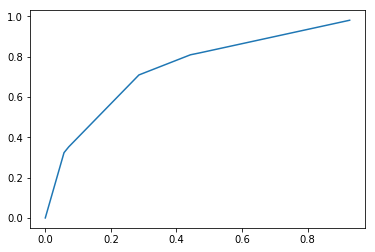

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(TPR_all,FPR_all)